# 계절학기 - AI 8팀
| RAG 챗봇
## 목차
***
### 1. Solar mini API 통신
### 2. CSV 파싱
### 3. 문서 임베딩
#### 3-1. 문서 가공/필터링
#### 3-2. Chroma 벡터 DB 저장
## 4. LLM 쿼리
### 4-1. Query 입력
### 4-2. Retriever 병렬 처리
### 4-3. Context 병합
### 4-4. 질의 답변 생성
***

### 필요한 라이브러리 다운로드

In [ ]:
!pip install -qU openai langchain langchain-upstage langchain-chroma getpass4

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googletrans 4.0.0rc1 requires httpx==0.13.3, but you have httpx 0.28.1 which is incompatible.


In [ ]:
!pip install googletrans==4.0.0-rc1 tqdm nest_asyncio

  Using cached httpx-0.13.3-py3-none-any.whl.metadata (25 kB)
  Using cached httpcore-0.9.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached h11-0.9.0-py2.py3-none-any.whl.metadata (8.1 kB)
Using cached httpx-0.13.3-py3-none-any.whl (55 kB)
Using cached httpcore-0.9.1-py3-none-any.whl (42 kB)
Using cached h11-0.9.0-py2.py3-none-any.whl (53 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.16.0
    Uninstalling h11-0.16.0:
      Successfully uninstalled h11-0.16.0
  Attempting uninstall: httpcore
    Found existing installation: httpcore 1.0.9
    Uninstalling httpcore-1.0.9:
      Successfully uninstalled httpcore-1.0.9
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chromadb 1.0.15 requires

https://console.upstage.ai/api-keys

In [ ]:
# @title set API key
import os
import getpass
import warnings

warnings.filterwarnings("ignore")

# Get the Upstage API key using getpass
os.environ["UPSTAGE_API_KEY"] = getpass.getpass("Enter your Upstage API key: ")

print("API key has been set successfully.")

Enter your Upstage API key: ··········
API key has been set successfully.


# 문서 임베딩
| vector DB 생성 이후 생략

In [ ]:
import asyncio
from googletrans import Translator
from tqdm.asyncio import tqdm
import nest_asyncio

nest_asyncio.apply()

translator = Translator()

async def translate_en_to_ko_async(text):
    """개별 문장을 번역"""
    loop = asyncio.get_event_loop()
    translated = await loop.run_in_executor(None, lambda: translator.translate(text, src='en', dest='ko'))
    return translated.text

async def batch_translate_texts(text_list):
    """리스트 전체를 tqdm과 함께 비동기로 번역"""
    translated_list = []
    for coro in tqdm(asyncio.as_completed([translate_en_to_ko_async(t) for t in text_list]), total=len(text_list)):
        translated_text = await coro
        translated_list.append(translated_text)
    return translated_list

# 예시 사용
if __name__ == "__main__":
    example_list = [
        "Atopic dermatitis",
        "Acute bronchitis",
        "Chronic sinusitis",
        "Hypertension",
        "Diabetes mellitus"
    ]

    translated_texts = asyncio.run(batch_translate_texts(example_list))
    print("\n✅ 번역 완료 결과:")
    for t in translated_texts:
        print(t)

AttributeError: module 'httpcore' has no attribute 'SyncHTTPTransport'

## CSV 파싱

In [ ]:
# @title patients.csv (환자 기본 정보)

from langchain.schema import Document
import pandas as pd
from typing import List

# patients.csv 읽기 (환자 기본 정보)
df = pd.read_csv("patients.csv")

# csv에서 사례화
def row_to_text(row) -> str:
    text = (
        f"환자 ID: {row['Id'][0:8]}\n"
        f"기본 정보: {row['BIRTHDATE']}에 태어났고, 성별은 {row['GENDER']}, 인종은 {row['RACE']}, 민족성은 {row['ETHNICITY']}입니다."
        # 나이 추가할 것
    )
    return text

texts = df.apply(row_to_text, axis=1).tolist()

# 문서 리스트 준비
patients_docs = []
for _, row in df.iterrows():
    text = row_to_text(row)
    patients_docs.append(Document(page_content=text, metadata={"patient_id": row["Id"][0:8], "table": "patients"}))

print("총 문서 수:", len(patients_docs))
print("예시 문서:\n", patients_docs[1].page_content)

총 문서 수: 1182
예시 문서:
 환자 ID: a0c8480c
기본 정보: 2024-01-09에 태어났고, 성별은 F, 인종은 white, 민족성은 nonhispanic입니다.


In [ ]:
# @title conditions.csv

import pandas as pd
from langchain.schema import Document
import numpy as np
from googletrans import Translator
from tqdm import tqdm

# ✅ Translator 초기화
translator = Translator()

# ✅ 동기 번역 함수 with tqdm
def batch_translate_sync(text_list):
    translated_list = []
    for text in tqdm(text_list, desc="진단명 번역 중"):
        translated = translator.translate(text, src='en', dest='ko')
        translated_list.append(translated.text)
    return translated_list

# ✅ CSV 읽기
df = pd.read_csv("conditions.csv")

# disorder만 필터링
df = df[df["DESCRIPTION"].str.contains(r"\(disorder\)", na=False)].copy()

# ✅ (disorder) 제거
df["DESCRIPTION"] = df["DESCRIPTION"].str.replace(r"\s*\(disorder\)", "", regex=True)

# ✅ STOP이 null이면 "현재"로 대체
df["STOP"] = df["STOP"].fillna("현재")

# ✅ 영문 진단명 리스트 생성
unique_conditions = df["DESCRIPTION"].unique().tolist()

# ✅ 동기 번역 실행
translated_conditions = batch_translate_sync(unique_conditions)

# ✅ 영문 ↔ 한글 매핑 딕셔너리
en_to_ko = dict(zip(unique_conditions, translated_conditions))

# ✅ DESCRIPTION 컬럼을 한글로 변환
df["DESCRIPTION_KO"] = df["DESCRIPTION"].map(en_to_ko)

# ✅ PATIENT 기준 그룹화
grouped = df.groupby("PATIENT")

# ✅ 환자별 문서 생성 함수
def patient_conditions_to_text(patient_id, group_df):
    conditions_text = ""
    for _, row in group_df.iterrows():
        stop_date = row["STOP"]
        conditions_text += (
            f"{row['START']}부터 {stop_date}까지 "
            f"{row['DESCRIPTION_KO']} 진단 받았습니다. "
        )
    text = f"환자 ID: {patient_id[0:8]}\n해당 환자는 다음과 같은 질병을 진단 받았습니다. {conditions_text}"
    return text

# ✅ 문서 리스트 준비
conditions_docs = []
for patient_id, group_df in grouped:
    text = patient_conditions_to_text(patient_id, group_df)
    conditions_docs.append(Document(page_content=text, metadata={"patient_id": patient_id[0:8], "table": "conditions"}))

print("총 문서 수:", len(conditions_docs))
print("예시 문서:\n", conditions_docs[0].page_content)


진단명 번역 중: 100%|██████████| 190/190 [00:19<00:00,  9.58it/s]


총 문서 수: 1171
예시 문서:
 환자 ID: 0057c08f
해당 환자는 다음과 같은 질병을 진단 받았습니다. 2012-03-22부터 현재까지 빈혈증 진단 받았습니다. 2015-11-12부터 2015-11-27까지 치은염 진단 받았습니다. 2015-11-13부터 2015-12-08까지 바이러스 성 부비동염 진단 받았습니다. 2018-11-01부터 2018-11-24까지 바이러스 성 부비동염 진단 받았습니다. 2024-01-19부터 2024-02-02까지 치은염 진단 받았습니다. 2024-02-02부터 2024-02-02까지 치은 질병 진단 받았습니다. 


In [ ]:
import pandas as pd

# CSV 파일 경로를 지정합니다.
file_path = '/content/observations.csv'

# CSV 파일을 읽어들입니다.
df = pd.read_csv(file_path)

descriptions = ["Diastolic Blood Pressure", "Systolic Blood Pressure", "Body Weight", "Heart rate", "Tobacco smoking status"]

# 'DESCRIPTION'이 필요한 항목만 필터링
vital_signs_df = df[df['DESCRIPTION'].isin(descriptions)].copy()

# ✅ Tobacco smoking status는 UNITS가 없을 가능성이 크므로 빈 문자열로 채움
vital_signs_df.loc[vital_signs_df['DESCRIPTION'] == "Tobacco smoking status", 'UNITS'] = vital_signs_df.loc[vital_signs_df['DESCRIPTION'] == "Tobacco smoking status", 'UNITS'].fillna("")

# 필요한 컬럼만 남깁니다.
vital_signs_df = vital_signs_df[['DATE', 'PATIENT', 'ENCOUNTER', 'DESCRIPTION', 'VALUE', 'UNITS']]

# DESCRIPTION별로 열을 생성
pivot_df = vital_signs_df.pivot_table(
    index=['DATE', 'PATIENT', 'ENCOUNTER'],
    columns=['DESCRIPTION', 'UNITS'],
    values='VALUE',
    aggfunc='first'  # 여러 값이 있으면 첫 번째 값만 선택
)

# 피벗 후 컬럼 이름 평탄화
pivot_df.columns = [f'{desc} [{unit}]' if unit else f'{desc}' for desc, unit in pivot_df.columns]

# 새 CSV 파일로 저장
output_file_path = 'filtered_observations.csv'
pivot_df.to_csv(output_file_path)

print(f"새로운 CSV 파일이 '{output_file_path}'에 저장되었습니다.")

새로운 CSV 파일이 'filtered_observations.csv'에 저장되었습니다.


In [ ]:
# @title observations.csv (신체/바이탈 정보)
import pandas as pd
from langchain.schema import Document

# CSV 읽기
df = pd.read_csv("filtered_observations.csv")

# 사용할 descriptions
descriptions = ["Diastolic Blood Pressure", "Systolic Blood Pressure", "Body Weight", "Heart rate", "Tobacco smoking status"]

# 실제 컬럼명과 descriptions 매핑
description_to_col = {}

for desc in descriptions:
    matching_cols = [col for col in df.columns if desc == col.split(" [")[0]]
    if matching_cols:
        description_to_col[desc] = matching_cols[0]
    else:
        print(f"⚠️ '{desc}' 컬럼을 찾을 수 없습니다!")

# ✅ 필요한 컬럼만 추출
needed_cols = ["PATIENT"] + list(description_to_col.values())
df_filtered = df[needed_cols].copy()

# ✅ patient_id 기준 그룹화
grouped = df_filtered.groupby("PATIENT")

# Document 리스트
observation_docs = []

for patient_id, group_df in grouped:
    summary_parts = []
    smoking_str = ""

    for desc, col_name in description_to_col.items():
        if desc == "Tobacco smoking status":
            # 최빈값 (mode) 가져오기
            if group_df[col_name].notna().any():
                mode_value = group_df[col_name].mode().iloc[0]
                # 텍스트 변환
                if "Never smoked" in mode_value:
                    smoking_str = "비흡연"
                elif "Ex-smoker" in mode_value:
                    smoking_str = "흡연"
                else:
                    smoking_str = "알 수 없음"
        else:
            mean_value = group_df[col_name].mean(skipna=True)
            if pd.notna(mean_value):
                if desc == "Body Weight":
                    value_str = f"{mean_value:.1f}"  # 소수 첫째 자리
                else:
                    value_str = f"{int(round(mean_value))}"  # 정수로
                summary_parts.append(f"{desc}: {value_str}")

    combined_text = (
        f"환자 ID: {patient_id[:8]}\n"
        f"환자는 다음과 같은 평균 바이탈/검사 정보를 갖습니다: " + ", ".join(summary_parts)
    )

    if smoking_str:
        combined_text += f"\n흡연 여부: {smoking_str}"

    observation_docs.append(Document(page_content=combined_text, metadata={"patient_id": patient_id[:8], "table": "observations"}))

In [ ]:
print("총 환자 수 (문서 수):", len(observation_docs))
print("예시 문서:\n", observation_docs[0].page_content)

총 환자 수 (문서 수): 1182
예시 문서:
 환자 ID: 0057c08f
환자는 다음과 같은 평균 바이탈/검사 정보를 갖습니다: Diastolic Blood Pressure: 78, Systolic Blood Pressure: 104, Body Weight: 95.1, Heart rate: 80
흡연 여부: 비흡연


In [ ]:
# @title procedures.csv

# procedure.csv 전처리

# 1️⃣ CSV 파일 불러오기
df = pd.read_csv("procedures.csv", parse_dates=["START"])

# 2️⃣ 날짜만 추출
df["DATE"] = df["START"].dt.date

# 3️⃣ 환자 + 날짜별로 DESCRIPTION 리스트 묶기
grouped_df = df.groupby(["PATIENT", "DATE"])["DESCRIPTION"].apply(list).reset_index()

# 4️⃣ 리스트를 문자열로 변환 (옵션: 보기 좋게 쉼표로 구분)
grouped_df["PROCEDURES"] = grouped_df["DESCRIPTION"].apply(lambda x: ", ".join(x))

# 5️⃣ 결과에서 원래 DESCRIPTION 열 제거
grouped_df.drop("DESCRIPTION", axis=1, inplace=True)

# 6️⃣ CSV 파일로 저장
grouped_df.to_csv("grouped_procedures.csv", index=False)

In [ ]:
import pandas as pd
import re

# CSV 파일 읽기
df = pd.read_csv("grouped_procedures.csv")

# PROCEDURES 컬럼 전처리 함수 정의
def clean_procedures(procedure_str):
    if pd.isna(procedure_str):
        return ""

    items = [item.strip() for item in procedure_str.split(',')]
    cleaned = []

    for item in items:
        # 괄호 안의 내용 추출
        match = re.search(r'\((.*?)\)', item)
        if match:
            content_in_parens = match.group(1).strip()
            if content_in_parens == "physical object":
                continue  # 해당 항목 전체 삭제
            else:
                # 괄호 안만 제거
                item = re.sub(r'\s*\(.*?\)', '', item).strip()
        cleaned.append(item)

    return ', '.join(cleaned)

# 기존 PROCEDURES 컬럼을 전처리해서 덮어쓰기
df['PROCEDURES'] = df['PROCEDURES'].apply(clean_procedures)

# 결과를 새 CSV로 저장
df.to_csv("cleaned_grouped_procedures.csv", index=False)

print("✅ 완료: 기존 'PROCEDURES' 컬럼이 정제되어 saved → cleaned_grouped_procedures.csv")


✅ 완료: 기존 'PROCEDURES' 컬럼이 정제되어 saved → cleaned_grouped_procedures.csv


In [ ]:
import pandas as pd
import re
from langchain.schema import Document
from tqdm import tqdm
from googletrans import Translator

translator = Translator()

# CSV 읽기
df = pd.read_csv("cleaned_grouped_procedures.csv")

# 환자 ID 앞 8자리만 사용
df["PATIENT_SHORT"] = df["PATIENT"].str[:8]

# PROCEDURES 컬럼에서 리스트로 분리
df["PROCEDURES_LIST"] = df["PROCEDURES"].str.split(", ")

# ✅ 모든 고유 수술명 추출
all_procs_flat = [proc for sublist in df["PROCEDURES_LIST"] if isinstance(sublist, list) for proc in sublist]
unique_procs = list(set(all_procs_flat))

print(f"수술명 개수: {len(unique_procs)}")

# ✅ 수술명 한글 번역
proc_en_to_ko = {}
for proc in tqdm(unique_procs, desc="수술명 번역 중"):
    try:
        translated = translator.translate(proc, src='en', dest='ko').text
        proc_en_to_ko[proc] = translated
    except Exception as e:
        print(f"⚠️ 번역 실패: {proc} → {e}")
        proc_en_to_ko[proc] = proc  # 실패 시 원문 유지

# ✅ 그룹화
grouped = df.groupby("PATIENT_SHORT")

procedures_docs = []

for patient_id, group in grouped:
    all_procs = []
    for proc_list in group["PROCEDURES_LIST"]:
        if isinstance(proc_list, list):
            all_procs.extend(proc_list)

    # 중복 제거
    unique_group_procs = sorted(set(all_procs))

    # 번역 적용
    translated_group_procs = [proc_en_to_ko.get(p, p) for p in unique_group_procs]

    # 텍스트 구성
    text = f"환자 ID: {patient_id}\n수술 이력: {', '.join(translated_group_procs)}"

    # Document 객체 추가
    procedures_docs.append(
        Document(
            page_content=text,
            metadata={"patient_id": patient_id, "table": "procedures"}
        )
    )

print("생성된 문서 수:", len(procedures_docs))
print("예시 문서:\n", procedures_docs[0].page_content)


수술명 개수: 348


수술명 번역 중: 100%|██████████| 348/348 [00:48<00:00,  7.18it/s]


생성된 문서 수: 1182
예시 문서:
 환자 ID: 0057c08f
수술 이력: 불안의 평가, 건강 및 사회 복지 요구 평가, 물질 사용의 평가, 알코올 사용 장애 식별 테스트 - 소비를 사용한 평가, 탈감작 의료의 치과 적용, 치과 치료, 치과 상담 및 보고서, 치과 용 엑스레이 비트, 치과 수술 절차, 우울증 스크리닝, Gingivae의 검사, 치은 절제술 또는 치은 치지 성형술, 약물 조정, 구강 건강 교육, 치과 치료를위한 환자 진료 의뢰, 치과 절차를위한 수술 후 치료, 치과기구를 사용하여 모든 치아에서 하위 징징 기형 플라크 및 미적분학 제거, 치과기구를 사용하여 모든 치아에서 우위 플라크 및 미적분학 제거, 가정 폭력을위한 선별, 약물 남용을위한 선별


In [ ]:
import pandas as pd
import re
from langchain.schema import Document
from googletrans import Translator
from tqdm import tqdm

translator = Translator()

def parse_medication_description(text):
    s = str(text).strip()
    res = {"code":"", "drug_names":[], "dose_amounts":[], "form":"", "route_or_extra":""}

    m = re.search(r'\b(NDA|ANDA)\d+\b', s)
    if m:
        res["code"] = m.group()

    form_pattern = re.compile(
        r'\b(?:'
        r'Extended Release Oral Tablet|Extended Release Tablet|Oral Tablet|Sublingual Tablet|Chewable Tablet|Oral Capsule|'
        r'Intravenous Injection|Intramuscular Injection|Inhalation Solution|Mucosal Spray|Drug Implant|'
        r'Transdermal System|Injectable Suspension|Topical Cream|Intrauterine System|Ophthalmic Solution|'
        r'Tablet|Capsule|Injection|Solution|Cream|Pack|Inhaler|Syringe|Suspension|Auto-Injector|Oral Suspension|'
        r'Patch|System|Implant|Spray|Drop|Oral Gel|Injectable Solution|Pen Injector|Vaginal Ring|Vaginal System'
        r')\b',
        flags=re.IGNORECASE
    )
    fm = form_pattern.search(s)
    if fm:
        res["form"] = fm.group().title()
        s = s[:fm.end()]

    split_pattern = re.compile(
        r'\s+/\s+(?!(?:MG(?:/(?:ML|MG|ACTUAT|HR))?|ML(?:/ML)?|UNT/ML|ACTUAT)\b)',
        flags=re.IGNORECASE
    )
    segments = split_pattern.split(s)

    dose_pat = (
        r'\d+(?:\.\d+)?/\d+(?:\.\d+)?\s*MG(?:/ACTUAT)?'
        r'|'
        r'\d+(?:\.\d+)?\s*MG(?:/ACTUAT)'
        r'|'
        r'\d+\s*ACTUAT'
        r'|'
        r'\d+(?:\.\d+)?\s*(?:MG(?:/(?:ML|MG|HR))?|ML(?:/ML)?|UNT/ML|%|HR|MG/HR|Day(?:s)?)'
    )

    for seg in segments:
        seg = seg.strip()
        doses = re.findall(dose_pat, seg, flags=re.IGNORECASE)
        res["dose_amounts"].append(" / ".join(doses) if doses else "")
        name = seg
        for d in doses:
            name = re.sub(re.escape(d), "", name, flags=re.IGNORECASE)
        if res["form"]:
            name = re.sub(re.escape(fm.group()), "", name, flags=re.IGNORECASE)
        res["drug_names"].append(name.strip(" -"))

    return res

# ✅ CSV 읽기
df = pd.read_csv("medications.csv")
df["START"] = pd.to_datetime(df["START"])
df["STOP"] = pd.to_datetime(df["STOP"], errors="coerce")

# ✅ 제형 & reason
unique_forms = df["DESCRIPTION"].apply(lambda x: parse_medication_description(x)["form"]).unique()
unique_reasons_raw = pd.concat([df["REASONDESCRIPTION"].dropna()]).unique()

# ✅ reason 전처리 (괄호 제거)
unique_reasons_cleaned = [re.sub(r"\s*\(.*?\)", "", r).strip() for r in unique_reasons_raw]

# ✅ 제형 번역
form_translated = {}
print("제형 번역 중...")
for form in tqdm(unique_forms):
    if form:
        try:
            ko_form = translator.translate(form, src='en', dest='ko').text
        except:
            ko_form = form
        form_translated[form] = ko_form

# ✅ reason 번역
reason_translated = {}
print("사유 번역 중...")
for r_clean in tqdm(unique_reasons_cleaned):
    if r_clean:
        try:
            ko_reason = translator.translate(r_clean, src='en', dest='ko').text
        except:
            ko_reason = r_clean
        reason_translated[r_clean] = ko_reason

medication_docs = []
for pid, group in df.groupby("PATIENT"):
    lines = []
    for desc, sub in group.groupby("DESCRIPTION"):
        info = parse_medication_description(desc)
        drugs = info["drug_names"]
        doses = [d.lower() for d in info["dose_amounts"]]
        form = info["form"]
        form_ko = form_translated.get(form, form)

        reasons_raw = sub["REASONDESCRIPTION"].dropna().unique()
        reasons_cleaned = []
        for r in reasons_raw:
            r_clean = re.sub(r'\s*\(.*?\)', '', r).strip()
            reasons_cleaned.append(reason_translated.get(r_clean, r_clean))
        reason_t = f"사유: {', '.join(reasons_cleaned)}" if reasons_cleaned else ""

        st = sub["START"].min().strftime("%Y-%m")
        en = sub["STOP"].max()
        if pd.isna(en):
            period = f"{st} ~ "
        else:
            en = en.strftime("%Y-%m")
            period = st if st == en else f"{st} ~ {en}"
        cnt = sub["DISPENSES"].sum()

        lines.append(
            f"- 성분: {', '.join(drugs)}  "
            f"용량: {', '.join(doses)}  "
            f"제형: {form_ko}  "
            f"기간: {period}  "
            f"횟수: {cnt}회  "
            f"{reason_t}"
        )

    combined = f"환자 ID: {pid[:8]}\n환자는 다음 약물을 복용했습니다:\n" + "\n".join(lines)
    medication_docs.append(Document(
        page_content=combined,
        metadata={"patient_id": pid[:8], "table": "medications"}
    ))

print("환자 수:", len(medication_docs))
print(medication_docs[0].page_content)


제형 번역 중...


100%|██████████| 26/26 [00:02<00:00,  9.51it/s]


사유 번역 중...


100%|██████████| 60/60 [00:03<00:00, 15.09it/s]


환자 수: 1158
환자 ID: 0063c9a6
환자는 다음 약물을 복용했습니다:
- 성분: heparin sodium  porcine  용량: 1 ml / 5000 unt/ml  제형: 주입  기간: 2008-05  횟수: 1회  
- 성분: Furosemide  용량: 10 ml / 10 mg/ml  제형: 주입  기간: 2010-04  횟수: 10회  사유: 만성 울혈 성 심부전
- 성분: Propofol  용량: 100 ml / 10 mg/ml  제형: 주입  기간: 2008-05  횟수: 1회  
- 성분: Ondansetron  용량: 2 ml / 2 mg/ml  제형: 주입  기간: 2008-05  횟수: 1회  
- 성분: metoprolol succinate  용량: 24 hr / 100 mg  제형: 확장 릴리스 구강 정제  기간: 2008-05 ~   횟수: 24회  
- 성분: protamine sulfate (USP)  용량: 25 ml / 10 mg/ml  제형: 주입  기간: 2008-05  횟수: 1회  
- 성분: SUFentanil  용량: 5 ml / 0.05 mg/ml  제형: 주입  기간: 2008-05  횟수: 1회  
- 성분: Clopidogrel  용량: 75 mg  제형: 구강 정제  기간: 2008-05 ~   횟수: 24회  
- 성분: Furosemide  용량: 40 mg  제형: 구강 정제  기간: 2009-10 ~   횟수: 6회  사유: 만성 울혈 성 심부전
- 성분: Ibuprofen  용량: 200 mg  제형: 구강 정제  기간: 2008-11 ~ 2008-12  횟수: 1회  
- 성분: Midazolam  용량: 1 mg/ml  제형: 주사 가능한 솔루션  기간: 2008-05  횟수: 1회  
- 성분: Naproxen sodium  용량: 220 mg  제형: 구강 정제  기간: 2001-01 ~ 2001-02  횟수: 1회  
- 성분: Nitroglycerin  용량: 0.4 mg/ac

In [ ]:
# @title allergies.csv (알러지 반응 기록)

import pandas as pd
from langchain.schema import Document
import re
from googletrans import Translator
from tqdm import tqdm

translator = Translator()

# CSV 읽기
df = pd.read_csv("allergies.csv")

# 괄호 제거 후 고유한 DESCRIPTION 추출
df["DESCRIPTION_CLEAN"] = df["DESCRIPTION"].apply(lambda x: re.sub(r"\s*\(.*?\)", "", str(x)).strip())
unique_allergies = df["DESCRIPTION_CLEAN"].unique().tolist()

# 동기 번역
translated_allergies = []
for desc in tqdm(unique_allergies, desc="알러지명 번역 중"):
    try:
        translated = translator.translate(desc, src='en', dest='ko').text
    except Exception as e:
        print(f"번역 오류: {desc} -> {e}")
        translated = desc
    translated_allergies.append(translated)

# 영어 → 한글 매핑
en_to_ko_allergies = dict(zip(unique_allergies, translated_allergies))

# DESCRIPTION_KO 컬럼 생성
df["DESCRIPTION_KO"] = df["DESCRIPTION_CLEAN"].map(en_to_ko_allergies)

# 환자별 그룹화
grouped = df.groupby("PATIENT")

# 문서 리스트
allergy_docs = []

for patient_id, group in grouped:
    text_lines = []
    for _, row in group.iterrows():
        line = f"{row['DESCRIPTION_KO']}"
        text_lines.append(line)

    combined_text = f"환자 ID: {patient_id[:8]}\n환자는 다음과 같은 알레르기 반응을 보였습니다:\n" + "\n".join(text_lines)

    allergy_docs.append(Document(page_content=combined_text, metadata={"patient_id": patient_id[:8], "table": "allergies"}))

print("환자 수 (문서 수):", len(allergy_docs))
print("예시 문서:\n", allergy_docs[20].page_content)

알러지명 번역 중: 100%|██████████| 22/22 [00:02<00:00,  9.58it/s]


환자 수 (문서 수): 202
예시 문서:
 환자 ID: 18ebb069
환자는 다음과 같은 알레르기 반응을 보였습니다:
알레르기 성 배치
아스피린


In [ ]:
import re
from collections import defaultdict
from datetime import datetime
from langchain.schema import Document

# ✅ 모든 docs 합치기
all_docs = patients_docs + conditions_docs + observation_docs + medication_docs + allergy_docs + procedures_docs

# ✅ patient_id 기준 그룹화
patient_groups = defaultdict(list)
for doc in all_docs:
    pid = doc.metadata.get("patient_id")
    if pid:
        patient_groups[pid].append(doc)

def create_cases_by_medications(pid, docs):
    # 기본 정보
    age_str = "알 수 없음"
    gender_str = "알 수 없음"
    weight_str = "알 수 없음"
    systolic_str = "알 수 없음"
    diastolic_str = "알 수 없음"
    conditions_str = "없습니다."
    smoking_str = "비흡연"  # 기본값
    allergies_str = "없습니다."
    procedures_str = "없습니다."

    # 각 환자 기본 및 바이탈 정보 먼저 파싱
    for doc in docs:
        table = doc.metadata.get("table")
        if table == "patients":
            content = doc.page_content
            birth_match = re.search(r'기본 정보: (\d{4})', content)
            if birth_match:
                birth_year = int(birth_match.group(1))
                age = datetime.now().year - birth_year
                age_str = f"{age}"

            gender_match = re.search(r'성별은 (\w)', content)
            if gender_match:
                gender_raw = gender_match.group(1)
                gender_str = "남성" if gender_raw == "M" else "여성"

        if table == "observations":
            bw_match = re.search(r'Body Weight: (\d+\.\d+)', doc.page_content)
            if bw_match:
                weight_str = bw_match.group(1)

            sys_match = re.search(r'Systolic Blood Pressure: (\d+)', doc.page_content)
            if sys_match:
                systolic_str = sys_match.group(1)

            dia_match = re.search(r'Diastolic Blood Pressure: (\d+)', doc.page_content)
            if dia_match:
                diastolic_str = dia_match.group(1)
            smoke_match = re.search(r'흡연 여부: ([가-힣]+)', doc.page_content)
            if smoke_match:
                smoking_str = smoke_match.group(1)
            else:
                smoking_str = "비흡연"  # 혹시 없을 경우 기본값

        if table == "conditions":
            # 한글 번역된 description에 맞춘 정규식
            conditions_matches = re.findall(r'\d{4}-\d{2}-\d{2}부터 .*?까지 (.+?) 진단 받았습니다\.', doc.page_content)
            if conditions_matches:
                conditions_str = ", ".join(set(conditions_matches)) + " 있습니다."
            else:
                conditions_str = "없습니다."

        if table == "allergies":
            # 줄바꿈 기준으로 나누기
            lines = doc.page_content.split("\n")
            if len(lines) >= 3:
                # 세 번째 줄부터 알레르기 항목
                allergy_items = lines[2:]

                # 불필요한 공백 제거
                allergies_only = ", ".join([item.strip() for item in allergy_items if item.strip()])

                if allergies_only and allergies_only.lower() != "없음":
                    allergies_str = allergies_only + " 있습니다."
                else:
                    allergies_str = "없습니다."
            else:
                allergies_str = "없습니다."

        if table == "procedures":
            parts = doc.page_content.split("수술 이력:")
            if len(parts) > 1:
                procedures_raw = parts[1].strip()
                procedures_list = [proc.strip() for proc in procedures_raw.split(",")]
                unique_procedures = sorted(set(procedures_list))
                procedures_str = ", ".join(unique_procedures) + " 있습니다."
            else:
                procedures_str = "없습니다."

    # ✅ 약물 문서 찾아서 여러 개로 분리
    cases = []
    for doc in docs:
        if doc.metadata.get("table") == "medications":
            med_lines = re.findall(
                r'- 성분: (.+?)  용량: (.+?)  제형: (.+?)  기간: (.+?)  횟수: (\d+)회(?:  사유: (.*))?',
                doc.page_content
            )
            for med_name, med_dose, med_form, med_period, med_count, med_reason in med_lines:
                reason_str = f"{med_reason}를 이유로" if med_reason and med_reason.strip() else ""
                text = (
                    f"만 {age_str}세 {weight_str}kg의 환자는 "
                    f"최고 혈압은 {systolic_str}, 최저 혈압은 {diastolic_str}, "
                    f"기저질환은 {conditions_str} "
                    f"성별은 {gender_str}, {smoking_str}자 입니다. "
                    f"{reason_str} {med_name}(을/를) {med_count}회 {med_dose}씩 {med_form} 복용했습니다. "
                    f"알러지는 {allergies_str} 수술 이력은 {procedures_str}"
                )
                cases.append(Document(page_content=text, metadata={"patient_id": pid, "table": "merged_summary"}))

    # ✅ 약물 정보 없으면 하나만 생성
    if not cases:
        text = (
            f"만 {age_str}세 {weight_str}kg의 환자는 "
            f"최고 혈압은 {systolic_str}, 최저 혈압은 {diastolic_str}, "
            f"기저질환은 {conditions_str} "
            f"성별은 {gender_str}, {smoking_str}자 입니다. "
            f" 복용 약물 정보는 없습니다. "
            f"알러지는 {allergies_str} 수술 이력은 {procedures_str}"
        )
        cases.append(Document(page_content=text, metadata={"patient_id": pid, "table": "merged_summary"}))

    return cases

# ✅ 최종 문서 생성
merged_docs = []
for pid, docs in patient_groups.items():
    cases = create_cases_by_medications(pid, docs)
    merged_docs.extend(cases)

print("생성된 문서 수:", len(merged_docs))
for i in range (0, 100):
  print("예시 문서:\n", merged_docs[i].page_content)

생성된 문서 수: 8166
예시 문서:
 만 3세 8.6kg의 환자는 최고 혈압은 144, 최저 혈압은 77, 기저질환은 없습니다. 성별은 남성, 비흡연자 입니다.  NDA020800  Epinephrine(을/를) 19회 0.3 ml / 1 mg/ml씩 자동 주사기 복용했습니다. 알러지는 알레르기 성 배치, 곰팡이, 집 먼지 진드기, 동물 반드시, 나무 꽃가루, 밀, 땅콩 있습니다. 수술 이력은 알레르기 선별 검사, 약물 조정 있습니다.
예시 문서:
 만 3세 8.6kg의 환자는 최고 혈압은 144, 최저 혈압은 77, 기저질환은 없습니다. 성별은 남성, 비흡연자 입니다.  cetirizine hydrochloride(을/를) 19회 5 mg씩 구강 정제 복용했습니다. 알러지는 알레르기 성 배치, 곰팡이, 집 먼지 진드기, 동물 반드시, 나무 꽃가루, 밀, 땅콩 있습니다. 수술 이력은 알레르기 선별 검사, 약물 조정 있습니다.
예시 문서:
 만 1세 6.7kg의 환자는 최고 혈압은 130, 최저 혈압은 91, 기저질환은 급성 기관지염, 아토피 성 피부염 있습니다. 성별은 여성, 비흡연자 입니다. 급성 기관지염를 이유로 Acetaminophen(을/를) 1회 325 mg씩 구강 정제 복용했습니다. 알러지는 없습니다. 수술 이력은 약물 조정 있습니다.
예시 문서:
 만 40세 87.4kg의 환자는 최고 혈압은 141, 최저 혈압은 77, 기저질환은 발작 장애, 부패, 급성 바이러스 성 인두염, 빈혈증, 발목의 염좌, 바이러스 성 부비동염 있습니다. 성별은 남성, 비흡연자 입니다. 부패를 이유로 vancomycin(을/를) 1회 150 ml / 5 mg/ml씩 주입 복용했습니다. 알러지는 없습니다. 수술 이력은 electroencephalogram, 가정 폭력을위한 선별, 건강 및 사회 복지 요구 평가, 목구멍 문화, 물질 사용의 평가, 불안의 평가, 스텝 다운 장치로 전송, 알코올 사용 장애 식별 테스트 - 소비를 사용한 평가, 약물 남용을위한 선별, 우울증 스

In [ ]:
import numpy as np

# 각 문서의 문자열 길이 측정
lengths = [len(doc.page_content) for doc in merged_docs]

# 통계 계산
avg_len = np.mean(lengths)
median_len = np.median(lengths)
min_len = np.min(lengths)
max_len = np.max(lengths)

# 출력
print("총 문서 수:", len(lengths))
print(f"평균 문자열 길이: {avg_len:.2f}")
print(f"중앙값 문자열 길이: {median_len}")
print(f"최소 문자열 길이: {min_len}")
print(f"최대 문자열 길이: {max_len}")


총 문서 수: 8166
평균 문자열 길이: 912.91
중앙값 문자열 길이: 889.0
최소 문자열 길이: 114
최대 문자열 길이: 1804


## Chunking 작업

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Splitter 설정
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=0,
)

# 실제 split
splits = text_splitter.split_documents(merged_docs)

# 결과 출력
print("Splits:", len(splits))


Splits: 8166


In [ ]:
import pickle

# Split 저장
with open("splits.pkl", "wb") as f:
    pickle.dump(splits, f)

print("✅ splits.pkl 파일로 저장 완료!")


✅ splits.pkl 파일로 저장 완료!


In [ ]:
import pickle

# Split 로드
with open("splits.pkl", "rb") as f:
    splits = pickle.load(f)

print("✅ splits.pkl 파일에서 splits 로드 완료!")
print("Splits 개수:", len(splits))


✅ splits.pkl 파일에서 splits 로드 완료!
Splits 개수: 8166


### Plot 시각화

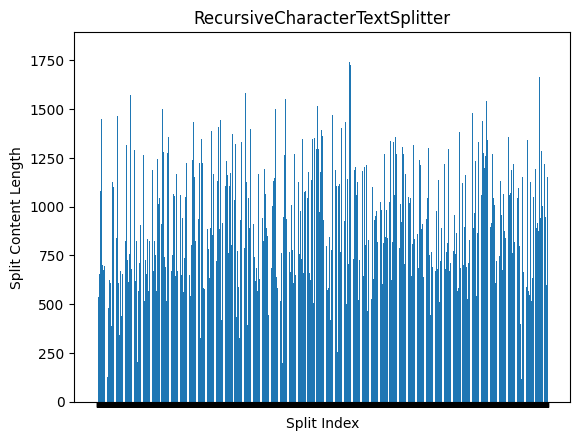

In [ ]:
# 시각화
import matplotlib.pyplot as plt

split_lengths = [len(split.page_content) for split in splits]

plt.bar(range(len(split_lengths)), split_lengths)
plt.title("RecursiveCharacterTextSplitter")
plt.xlabel("Split Index")
plt.ylabel("Split Content Length")
plt.xticks(range(len(split_lengths)), [])
plt.show()

## Vector DB 저장

In [ ]:
!pip install httpx==0.24.1

  Using cached httpx-0.24.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached httpcore-0.17.3-py3-none-any.whl.metadata (18 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
Using cached httpx-0.24.1-py3-none-any.whl (75 kB)
Using cached httpcore-0.17.3-py3-none-any.whl (74 kB)
Using cached h11-0.14.0-py3-none-any.whl (58 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.9.0
    Uninstalling h11-0.9.0:
      Successfully uninstalled h11-0.9.0
  Attempting uninstall: httpcore
    Found existing installation: httpcore 0.9.1
    Uninstalling httpcore-0.9.1:
      Successfully uninstalled httpcore-0.9.1
  Attempting uninstall: httpx
    Found existing installation: httpx 0.13.3
    Uninstalling httpx-0.13.3:
      Successfully uninstalled httpx-0.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googletrans 4.0.0rc1 requires h

In [ ]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings
from langchain.docstore.document import Document

In [ ]:
import time

# 1️⃣ Embeddings 객체 선언
embeddings = UpstageEmbeddings(model="embedding-query")

batch_size = 100  # 한 번에 처리할 문서 수

for i in range(0, len(splits), batch_size):
    batch = splits[i:i+batch_size]
    try:
        vectorstore = Chroma.from_documents(
            documents=batch,
            embedding=embeddings,
            persist_directory="./chroma_db1"
        )
    except Exception as e:
        print(f"Batch {i//batch_size + 1} 처리 중 오류 발생:", e)
        time.sleep(60)  # Rate limit 회피를 위해 잠시 대기


In [ ]:
# @title zip으로 압축/저장
!zip -r /content/chroma_db.zip /content/chroma_db1

  adding: content/chroma_db1/ (stored 0%)
  adding: content/chroma_db1/chroma.sqlite3 (deflated 73%)
  adding: content/chroma_db1/fe3314cf-1083-48d1-82f5-b6d5483858d3/ (stored 0%)
  adding: content/chroma_db1/fe3314cf-1083-48d1-82f5-b6d5483858d3/header.bin (deflated 55%)
  adding: content/chroma_db1/fe3314cf-1083-48d1-82f5-b6d5483858d3/data_level0.bin (deflated 53%)
  adding: content/chroma_db1/fe3314cf-1083-48d1-82f5-b6d5483858d3/length.bin (deflated 100%)
  adding: content/chroma_db1/fe3314cf-1083-48d1-82f5-b6d5483858d3/link_lists.bin (deflated 80%)
  adding: content/chroma_db1/fe3314cf-1083-48d1-82f5-b6d5483858d3/index_metadata.pickle (deflated 45%)


# Vector DB 로드

In [ ]:
# @title 압축 풀기
!unzip /content/chroma_db.zip -d ./

Archive:  /content/chroma_db.zip
   creating: /content/chroma_db/content/chroma_db/content/chroma_db/
  inflating: /content/chroma_db/content/chroma_db/content/chroma_db/chroma.sqlite3  
   creating: /content/chroma_db/content/chroma_db/content/chroma_db/0b73a7ae-b747-4a33-bb10-4a03fb090c54/
  inflating: /content/chroma_db/content/chroma_db/content/chroma_db/0b73a7ae-b747-4a33-bb10-4a03fb090c54/length.bin  
  inflating: /content/chroma_db/content/chroma_db/content/chroma_db/0b73a7ae-b747-4a33-bb10-4a03fb090c54/index_metadata.pickle  
  inflating: /content/chroma_db/content/chroma_db/content/chroma_db/0b73a7ae-b747-4a33-bb10-4a03fb090c54/data_level0.bin  
  inflating: /content/chroma_db/content/chroma_db/content/chroma_db/0b73a7ae-b747-4a33-bb10-4a03fb090c54/link_lists.bin  
  inflating: /content/chroma_db/content/chroma_db/content/chroma_db/0b73a7ae-b747-4a33-bb10-4a03fb090c54/header.bin  


In [ ]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings
from langchain.docstore.document import Document

# 1️⃣ Embeddings 객체 선언
embeddings = UpstageEmbeddings(model="embedding-query")

vectorstore = Chroma(
    persist_directory="/content/chroma_db/content/chroma_db",
    embedding_function=embeddings
)

# LLM 생성

In [ ]:
# ✅ 사용자의 한국어 질문 예시
query = "환자가 심장이 아프다고 하는데, 어떤 약물을 투약해야 돼?"

# ✅ Dense Retriever 생성
retriever = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 5},
)

## similarity
# retriever = vectorstore.as_retriever(
#     search_type="similarity_score_threshold",
#     search_kwargs={"k": 5, "score_threshold": 0.1},
# )

# print(retriever)

results = vectorstore.similarity_search_with_score(query, k=5)

for doc, score in results:
    print(f"Score: {score}")
    print(f"Content: {doc.page_content}")
    print("-" * 30)

# ✅ 검색된 문서 가져오기
docs = retriever.invoke(query)

# ✅ 한국어 system 프롬프트 정의
from langchain_upstage import ChatUpstage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatUpstage()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            당신은 환자 정보 기반으로 약물 투여를 제안하는 한국어 의료 AI 어시스턴트입니다.

            아래 CONTEXT는 하나의 통합된 환자 사례 정보로 제공됩니다. 이 정보를 참고하여 전문 의료진에게 전달할 수 있도록 간결하고 핵심적으로 요약해 주세요.

            - CONTEXT에 포함되지 않은 내용은 절대 작성하지 마세요. 모르면 "모른다"고 명확히 답변하세요.
            - 의료진이 빠르게 참고할 수 있도록 문단 형태로 정리하며, 불필요한 수식어는 생략하고 중요한 핵심 정보만 포함하세요.
            - 투약 권장 시, 환자의 기본 정보, 진단 질병, 바이탈/검사 결과, 기존 투약 기록, 알러지 정보를 함께 고려해 주세요.
            - 환자 ID는 CONTEXT 상단에 이미 명시되어 있으므로 다시 반복하지 마세요.

            간결하고 전문적인 톤으로 작성하며, 필요 시 투약 제안 및 주의사항도 포함하세요.
            ---
            CONTEXT:
            {context}
            """,
        ),
        ("human", "{input}"),
    ]
)

# ✅ LLM chain 구성
chain = prompt | llm | StrOutputParser()

# ✅ 최종 chain 호출
response = chain.invoke({"context": docs, "input": query})

print("\n💬 AI의 답변:")
print(response)


Score: 1.2072370052337646
Content: 만 88세 98.9kg의 환자는 최고 혈압은 73, 최저 혈압은 63, 기저질환은 팔뚝의 열상, 대동맥 판막 협착증, 급성 기관지염, 만성 울혈 성 심부전, 고지혈증, 필수 고혈압, 심근 경색, 급성 ST 세그먼트 고도 심근 경색, 빈혈증, 대사 증후군 x, 열상 - 부상, 치은염 있습니다. 성별은 남성, 비흡연자 입니다.  nitroglycerin(을/를) 1회 0.4 mg씩 설하 태블릿 복용했습니다. 알러지는 없습니다. 수술 이력은 Gingivae의 검사, Morse Fall Scale을 사용한 평가, 가슴의 평범한 엑스레이, 가정 폭력을위한 선별, 개별화 된 치료 계획의 개발, 건강 및 사회 복지 요구 평가, 경피 관상 동맥 중재, 관상 동맥의 혈관 조영술, 구강 건강 교육, 뉴욕 심장 협회 분류를 사용한 평가, 마스크에 의한 산소 투여, 모니터링 장치를 사용한 심장 상태 평가, 물질 사용의 평가, 봉합 된 상처, 불안의 평가, 실험실 테스트, 심 초음파, 심부전 교육, 심전도 절차, 알림, 알코올 사용 장애 식별 테스트 - 소비를 사용한 평가, 약물 남용을위한 선별, 약물 조정, 우울증 스크리닝, 인증 절차, 주제를 쉽게 위치에 놓습니다, 진단 평가, 초기 환자 평가, 치과 불소 처리, 치과 상담 및 보고서, 치과 용 엑스레이 비트, 치과 충전재를 사용하여 모든 교두의 커버리지로 치아의 복원, 치과 치료, 치과 치료를위한 환자 진료 의뢰, 치과기구를 사용하여 모든 치아에서 우위 플라크 및 미적분학 제거, 치과기구를 사용하여 모든 치아에서 하위 징징 기형 플라크 및 미적분학 제거, 치료를위한 상담, 호스피스 관리, 호흡기 기능 측정, 환자 건강 설문지 9 항목 점수를 사용한 우울증 스크리닝, 흉부 성 심 초음파 검사 있습니다.
------------------------------
Score: 1.218178629875183
Content: 만 83세 83.4kg의 환자는 최고 혈압은 109,